<a href="https://colab.research.google.com/github/danimadhavapuri/Quantum-Fraud-Detection/blob/main/Hybrid_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Hybrid QML + ML Fraud Detection — Colab Notebook (Full Pipeline)
**How to use:**  
1. In Colab: *Runtime → Change runtime type → Python version → 3.10* (important).  
2. Then: *Runtime → Restart runtime*.  
3. Run all cells (Runtime → Run all).

This notebook is a self-contained demo: synthetic data → graph → Node2Vec embeddings → classical baseline (XGBoost) → QML classifier (PennyLane simulator) → hybrid fusion → evaluation & visualization. Designed to run on Colab CPU/GPU.  


In [ ]:
# Install compatible packages
# NOTE: If you are on Colab, please set Python version to 3.10 (Runtime -> Change runtime type -> Python version -> 3.10)
# Then restart runtime and run this cell.
!pip install --quiet numpy==1.23.5 pandas networkx scikit-learn matplotlib seaborn xgboost node2vec joblib pennylane pennylane-qiskit qiskit torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1
print('Install finished')

  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Install finished


In [ ]:
# Imports and folders
import os, random, math
import numpy as np, pandas as pd, networkx as nx
from datetime import datetime, timedelta
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import joblib
import torch, torch.nn as nn
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
random.seed(42)
np.random.seed(42)
print('Imports loaded')

Imports loaded


In [ ]:
import os
import random
import pandas as pd
from datetime import datetime, timedelta

# ✅ Synthetic transaction generator
def generate_transactions(out_csv="data/processed/transactions.csv",
                          num_merchants=120, num_users=400, collusive_groups=4):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)

    txns = []
    merchants = [f"M{i}" for i in range(num_merchants)]
    users = [f"U{i}" for i in range(num_users)]
    start = datetime.now() - timedelta(days=30)

    # Normal user → merchant transactions
    for _ in range(100):
        s = random.choice(users)
        r = random.choice(merchants)
        t = start + timedelta(minutes=random.randint(0, 60*24*30))
        amt = round(random.uniform(10, 2000), 2)
        txns.append((s, r, t.isoformat(), amt))

    # Random merchant → merchant transactions
    for _ in range(50):
        a, b = random.sample(merchants, 2)
        t = start + timedelta(minutes=random.randint(0, 60*24*30))
        amt = round(random.uniform(5, 5000), 2)
        txns.append((a, b, t.isoformat(), amt))

    # Collusive merchant groups
    collusive_nodes = set()
    for g in range(collusive_groups):
        size = random.randint(3, 5)
        group = random.sample(merchants, size)
        collusive_nodes.update(group)
        base_time = start + timedelta(days=random.randint(0, 29))
        for _ in range(20):
            for i in range(len(group)):
                a = group[i]
                b = group[(i+1) % len(group)]
                t = base_time + timedelta(minutes=random.randint(0, 60*6))
                amt = round(random.uniform(1000, 20000), 2)
                txns.append((a, b, t.isoformat(), amt))

    df = pd.DataFrame(txns, columns=["sender", "receiver", "timestamp", "amount"])
    df.to_csv(out_csv, index=False)
    print(f"✅ Saved {len(df)} transactions to {out_csv}. Collusive nodes approx: {len(collusive_nodes)}")
    return df

# 👉 Run Step 1
df = generate_transactions()
df.head()


✅ Saved 2660 transactions to data/processed/transactions.csv. Collusive nodes approx: 18


,sender,receiver,timestamp,amount
0,U327,M14,2025-08-12T10:29:07.188303,1485.69
1,U125,M28,2025-08-17T15:34:07.188303,1475.58
2,U346,M94,2025-09-05T02:51:07.188303,183.01
3,U216,M4,2025-08-12T15:42:07.188303,196.45
4,U119,M64,2025-09-07T16:43:07.188303,62.81


In [ ]:
import pickle
import pandas as pd
import networkx as nx

# ✅ Graph builder
def build_graph(csv_path="data/processed/transactions.csv", out_g="data/processed/txn_graph.pkl"):
    df = pd.read_csv(csv_path)
    G = nx.DiGraph()

    for _, row in df.iterrows():
        a, b, amt, t = row["sender"], row["receiver"], row["amount"], pd.to_datetime(row["timestamp"])
        if G.has_edge(a, b):
            G[a][b]["count"] += 1
            G[a][b]["amount_sum"] += amt
            G[a][b]["last_ts"] = max(G[a][b]["last_ts"], t)
        else:
            G.add_edge(a, b, count=1, amount_sum=amt, last_ts=t)

    # Save graph object
    with open(out_g, "wb") as f:
        pickle.dump(G, f)

    print(f"✅ Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

def load_graph(path="data/processed/txn_graph.pkl"):
    with open(path, "rb") as f:
        return pickle.load(f)

# 👉 Run Step 2
G = build_graph()
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


✅ Graph built: 518 nodes, 2277 edges
Nodes: 518
Edges: 2277


In [ ]:
from collections import defaultdict

def extract_features(G, out_csv="data/processed/features.csv"):
    nodes = list(G.nodes())
    pagerank = nx.pagerank(G, alpha=0.85)
    indeg = dict(G.in_degree())
    outdeg = dict(G.out_degree())

    # ✅ Safer cycle feature: count triangles (fast)
    cycle_counts = defaultdict(int)
    for n in nodes:
        # neighbors that form 2-step paths
        for nbr in G.successors(n):
            for nnbr in G.successors(nbr):
                if G.has_edge(nnbr, n):  # triangle detected
                    cycle_counts[n] += 1

    # ✅ Strongly connected component size
    scc = {n: len(c) for c in nx.strongly_connected_components(G) for n in c}

    rows = []
    for n in nodes:
        rows.append({
            "node": n,
            "in_deg": indeg.get(n, 0),
            "out_deg": outdeg.get(n, 0),
            "pagerank": pagerank.get(n, 0.0),
            "cycle_count": cycle_counts.get(n, 0),  # lighter cycle metric
            "scc_size": scc.get(n, 1)
        })

    df = pd.DataFrame(rows)
    df["label"] = (df["cycle_count"] > 0).astype(int)  # mark cyclic nodes as fraud-like
    df.to_csv(out_csv, index=False)
    print(f"✅ Saved features for {len(df)} nodes to {out_csv}")
    return df

# Ensure graph is available
try:
    G
except NameError:
    # if not in memory, reload from pickle
    G = load_graph("data/processed/txn_graph.pkl")
feat = extract_features(G)
feat.head()

✅ Saved features for 518 nodes to data/processed/features.csv


,node,in_deg,out_deg,pagerank,cycle_count,scc_size,label
0,U327,0,6,0.000358,0,1,0
1,M14,21,7,0.003938,0,98,0
2,U125,0,7,0.000358,0,1,0
3,M28,27,1,0.002033,0,1,0
4,U346,0,5,0.000358,0,1,0


In [ ]:
!pip install node2vec

In [ ]:
# Node2Vec embeddings (CPU-friendly)
from node2vec import Node2Vec
nodes = list(G.nodes())
G_u = G.to_undirected()
node2vec = Node2Vec(G_u, dimensions=32, walk_length=20, num_walks=100, workers=2)
w2v_model = node2vec.fit(window=10, min_count=1)
emb = np.array([w2v_model.wv[n] for n in nodes])
np.save('data/processed/embeddings.npy', emb)
pd.DataFrame({'node': nodes}).to_csv('data/processed/node_index.csv', index=False)
print('Saved embeddings shape:', emb.shape)

Computing transition probabilities:   0%|          | 0/518 [00:00<?, ?it/s]

Saved embeddings shape: (518, 32)


In [ ]:
# Classical baseline (XGBoost)
from xgboost import XGBClassifier
X = feat[['in_deg','out_deg','pagerank','cycle_count','scc_size']].values
y = feat['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)
preds = clf.predict(X_test); probs = clf.predict_proba(X_test)[:,1]
print('XGBoost results:'); print(classification_report(y_test, preds))
print('XGBoost AUC:', roc_auc_score(y_test, probs))
joblib.dump(clf, 'data/processed/xgb_model.joblib')

XGBoost results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00         5

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

XGBoost AUC: 1.0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:11:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['data/processed/xgb_model.joblib']

In [ ]:
!pip install pennylane

In [ ]:
# QML classifier using PennyLane (simulator)
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pennylane as qml
import torch.nn as nn
import torch
import numpy as np
import pandas as pd

# --- Load embeddings and labels ---
emb_all = np.load('data/processed/embeddings.npy')
node_index = pd.read_csv('data/processed/node_index.csv')['node'].tolist()

# Load labels (adjust if labels are stored elsewhere)
feat = pd.read_csv("data/processed/features.csv")  # features file has 'node' and 'label'
label_map = dict(zip(feat['node'], feat['label']))
labels_all = np.array([label_map.get(n, 0) for n in node_index])

# --- Dimensionality reduction for QML input ---
n_qubits = 4
pca = PCA(n_components=n_qubits)
Xp = pca.fit_transform(emb_all)

scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
Xp = scaler.fit_transform(Xp)

# Train/test split
Xtr, Xte, ytr, yte = train_test_split(
    Xp, labels_all, test_size=0.2, random_state=42, stratify=labels_all
)

# --- Quantum device ---
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface='torch')
def circuit(inputs, weights):
    # Encode classical data
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    # Entangling layers
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    # Return expectation values (vector of length n_qubits)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define trainable weights
weight_shapes = {"weights": (3, n_qubits, 3)}  # 3 layers

# Wrap QNode into Torch layer (no batch_dim argument)
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

# --- QML Classifier ---
class QMLClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qlayer
        self.fc = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = self.qlayer(x)
        return torch.sigmoid(self.fc(x)).squeeze(-1)

# Instantiate model
model = QMLClassifier()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# Convert data to tensors
Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
ytr_t = torch.tensor(ytr, dtype=torch.float32)
Xte_t = torch.tensor(Xte, dtype=torch.float32)
yte_t = torch.tensor(yte, dtype=torch.float32)

# --- Training loop ---
epochs = 20
batch = 16  # smaller batch to save RAM
for epoch in range(epochs):
    model.train()
    perm = torch.randperm(Xtr_t.size(0))
    total_loss = 0.0

    for i in range(0, Xtr_t.size(0), batch):
        idx = perm[i:i+batch]
        xb = Xtr_t[idx]
        yb = ytr_t[idx]

        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)

    total_loss /= Xtr_t.size(0)

    # Validation
    model.eval()
    with torch.no_grad():
        preds_val = model(Xte_t).detach().numpy()
    try:
        auc = roc_auc_score(yte, preds_val)
    except Exception:
        auc = float("nan")

    if epoch % 5 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} loss={total_loss:.4f} val_auc={auc:.4f}")

# --- Save artifacts ---
torch.save(
    {"state": model.state_dict(), "pca": pca, "scaler": scaler},
    "data/processed/qml_model.pt"
)
print("✅ Saved QML artifacts")


Epoch 0 loss=0.6462 val_auc=0.4303
Epoch 5 loss=0.2462 val_auc=0.5515
Epoch 10 loss=0.2037 val_auc=0.5717
Epoch 15 loss=0.1907 val_auc=0.5960
Epoch 19 loss=0.1846 val_auc=0.6000
✅ Saved QML artifacts


In [ ]:
# Fusion: combine classical + QML probabilities using a simple logistic regression meta-model
with torch.no_grad():
    Xp_all = pca.transform(emb_all)
    Xp_all = scaler.transform(Xp_all)
    qml_probs_all = model(torch.tensor(Xp_all, dtype=torch.float32)).numpy()

xgb_probs_all = clf.predict_proba(feat[['in_deg','out_deg','pagerank','cycle_count','scc_size']].values)[:,1]

X_meta = np.vstack([xgb_probs_all, qml_probs_all]).T
y_meta = labels_all
X_m_tr, X_m_te, y_m_tr, y_m_te = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42, stratify=y_meta)

from sklearn.linear_model import LogisticRegression
meta = LogisticRegression().fit(X_m_tr, y_m_tr)
preds_meta = meta.predict(X_m_te); probs_meta = meta.predict_proba(X_m_te)[:,1]
print('Meta model results:'); print(classification_report(y_m_te, preds_meta))
print('Meta AUC:', roc_auc_score(y_m_te, probs_meta))
joblib.dump(meta, 'data/processed/meta_model.joblib')

Meta model results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00         5

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Meta AUC: 1.0


['data/processed/meta_model.joblib']

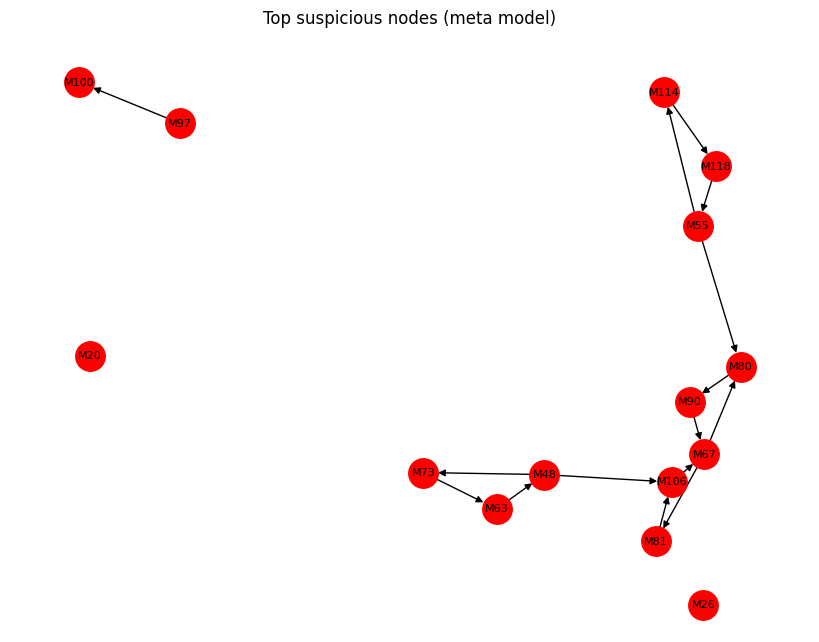

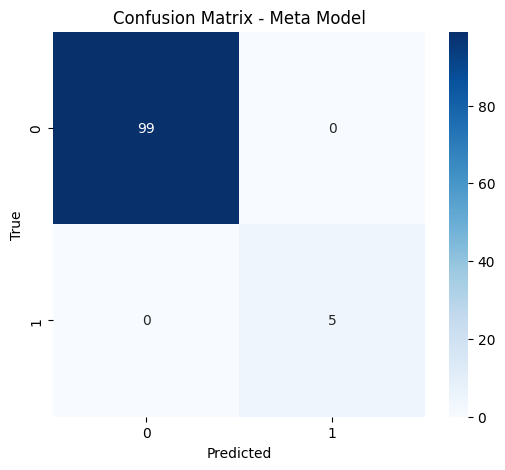

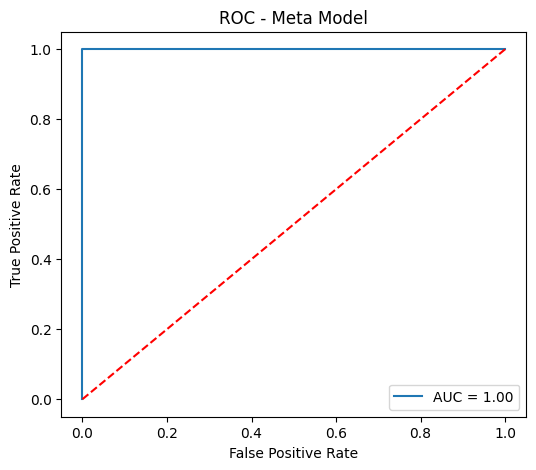

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- Top suspicious nodes visualization ---
feat['xgb_score'] = xgb_probs_all
feat['qml_score'] = qml_probs_all
feat['meta_score'] = meta.predict_proba(X_meta)[:,1]

top_nodes = feat.sort_values('meta_score', ascending=False).head(15)['node'].tolist()
H = G.subgraph(top_nodes).copy()
pos = nx.spring_layout(H, seed=42)

plt.figure(figsize=(8,6))
nx.draw(H, pos, with_labels=True, node_size=450, node_color='red', font_size=8)
plt.title('Top suspicious nodes (meta model)')
plt.show()

# --- Confusion matrix ---
cm = confusion_matrix(y_m_te, preds_meta)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Meta Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_m_te, probs_meta)
roc_auc_val = auc(fpr, tpr)  # use different name to avoid conflict

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_val:.2f}')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Meta Model')
plt.legend()
plt.show()


In [ ]:
# Zip results for download
!zip -r /content/qml_fraud_demo_results.zip data -q
from google.colab import files
files.download('/content/qml_fraud_demo_results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>